In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn

from models import MLP, NAC, NALU

In [2]:
arithmetic_functions = {
    'add': lambda x, y: x + y,
    'sub': lambda x, y: x - y,
    'mul': lambda x, y: x * y,
    'div': lambda x, y: x / y,
    'squared': lambda x: torch.pow(x, 2),
    'sqrt': lambda x: torch.sqrt(x)
}

In [3]:
def generate_data(dim, fn, support):
    X = torch.FloatTensor(*dim).uniform_(*support)
    y = fn(*[X[:, i] for i in range(dim[1])]).unsqueeze(1)
    return X, y

In [4]:
def train(model, optimizer, criterion, data, target, n_epochs):

    for epoch in range(n_epochs):

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        m = torch.mean(torch.abs(target - output))

        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print('Epoch {:05}:\t'
                  'Loss = {:.5f}\t'
                  'MEA = {:.5f}'.format(epoch, loss, m))

In [5]:
def test(model, data, target):

    with torch.no_grad():
        output = model(data)
        m = torch.mean(torch.abs(target - output))
        return m

In [6]:
hidden_dim = 2
n_layers = 2

interp_support = [1, 100]
extrap_support = [101, 200]

n_epochs = 10_000
lr = 0.01

In [7]:
results = {}
results['interp'] = {}
results['extrap'] = {}

for fn_type, fn in arithmetic_functions.items():
    
    if fn_type in ['squared', 'sqrt']:
        in_dim = 1
    else:
        in_dim = 2
    
    print('-> Testing function: {}'.format(fn_type))
    results['interp'][fn_type] = []
    results['extrap'][fn_type] = []

    Xtrain, ytrain = generate_data(
        dim=(500, in_dim), fn=fn, support=interp_support
    )

    Xtest_interp, ytest_interp = generate_data(
        dim=(50, in_dim), fn=fn, support=interp_support
    )

    Xtest_extrap, ytest_extrap = generate_data(
        dim=(50, in_dim), fn=fn, support=extrap_support
    )

    models = [
        MLP(in_dim=in_dim,
            hidden_dim=hidden_dim,
            out_dim=1,
            n_layers=n_layers,
            act=nn.ReLU6()),
        MLP(in_dim=in_dim,
            hidden_dim=hidden_dim,
            out_dim=1,
            n_layers=n_layers,
            act=None),
        NAC(in_dim=in_dim,
            hidden_dim=hidden_dim,
            out_dim=1,
            n_layers=n_layers),
        NALU(in_dim=in_dim,
             hidden_dim=hidden_dim,
             out_dim=1,
             n_layers=n_layers)
    ]
    
    for net in models:
        print('-> Running: {}'.format(net.__str__().split('(')[0]))
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train(net, optimizer, criterion, Xtrain, ytrain, n_epochs)

        interp_mse = test(net, Xtest_interp, ytest_interp).item()
        extrap_mse = test(net, Xtest_extrap, ytest_extrap).item()

        results['interp'][fn_type].append(interp_mse)
        results['extrap'][fn_type].append(extrap_mse)

-> Testing function: add
-> Running: MLP
Epoch 00000:	Loss = 11740.12891	MEA = 100.36977
Epoch 01000:	Loss = 408.18741	MEA = 13.49087
Epoch 02000:	Loss = 112.83696	MEA = 9.39868
Epoch 03000:	Loss = 106.57817	MEA = 9.36518
Epoch 04000:	Loss = 108.39638	MEA = 9.50050
Epoch 05000:	Loss = 106.08767	MEA = 9.36397
Epoch 06000:	Loss = 102.09818	MEA = 9.14213
Epoch 07000:	Loss = 101.81346	MEA = 9.12387
Epoch 08000:	Loss = 102.68555	MEA = 9.13379
Epoch 09000:	Loss = 103.38903	MEA = 9.17717
-> Running: MLP
Epoch 00000:	Loss = 15672.38965	MEA = 115.92477
Epoch 01000:	Loss = 1.71780	MEA = 1.27630
Epoch 02000:	Loss = 2.33685	MEA = 1.42776
Epoch 03000:	Loss = 2.32614	MEA = 1.41858
Epoch 04000:	Loss = 2.31622	MEA = 1.41502
Epoch 05000:	Loss = 2.30523	MEA = 1.41164
Epoch 06000:	Loss = 2.29271	MEA = 1.40785
Epoch 07000:	Loss = 2.27750	MEA = 1.40323
Epoch 08000:	Loss = 2.25994	MEA = 1.39790
Epoch 09000:	Loss = 2.23833	MEA = 1.39132
-> Running: NAC
Epoch 00000:	Loss = 11031.64355	MEA = 97.23607
Epoch 010

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df_interp = pd.DataFrame(results['interp'])
df_interp.index = ['MLP_NONE', 'MLP_RELU6', 'NAC', 'NALU']
df_interp

,add,sub,mul,div,squared,sqrt
MLP_NONE,8.394951,9.936478,1663.445801,1.113933,2397.117432,2.044306
MLP_RELU6,1.378315,0.476831,816.377686,1.583490,570.390503,0.355835
NAC,0.284855,0.239988,2436.162598,1.666297,2406.322266,1.194573
NALU,0.158009,4.679384,34.178577,0.000593,0.000427,0.059581


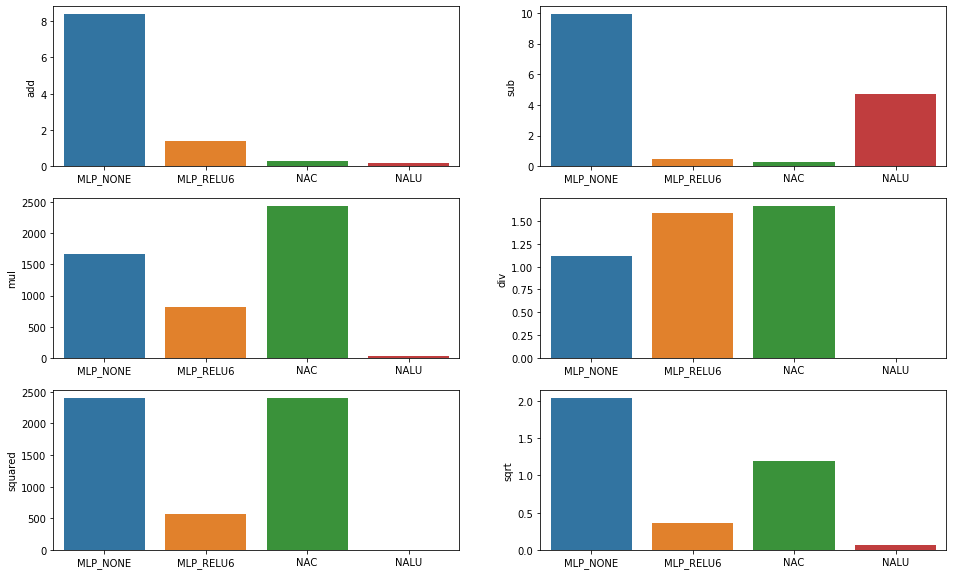

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(16,10))
axs = axs.flatten()

sns.barplot(x=df_interp.index, y='add', data=df_interp, ax=axs[0])
sns.barplot(x=df_interp.index, y='sub', data=df_interp, ax=axs[1])
sns.barplot(x=df_interp.index, y='mul', data=df_interp, ax=axs[2])
sns.barplot(x=df_interp.index, y='div', data=df_interp, ax=axs[3])
sns.barplot(x=df_interp.index, y='squared', data=df_interp, ax=axs[4])
sns.barplot(x=df_interp.index, y='sqrt', data=df_interp, ax=axs[5])

In [11]:
df_extrap = pd.DataFrame(results['extrap'])
df_extrap.index = ['MLP_NONE', 'MLP_RELU6', 'NAC', 'NALU']
df_extrap

,add,sub,mul,div,squared,sqrt
MLP_NONE,134.579163,22.899380,22070.937500,0.314527,25428.705078,5.424022
MLP_RELU6,4.054973,1.272972,10032.606445,1.836790,11507.692383,2.332551
NAC,0.857149,0.702628,22766.195312,4.484635,25215.533203,6.049031
NALU,0.165906,11.630957,365.133606,0.000724,0.006270,0.033440


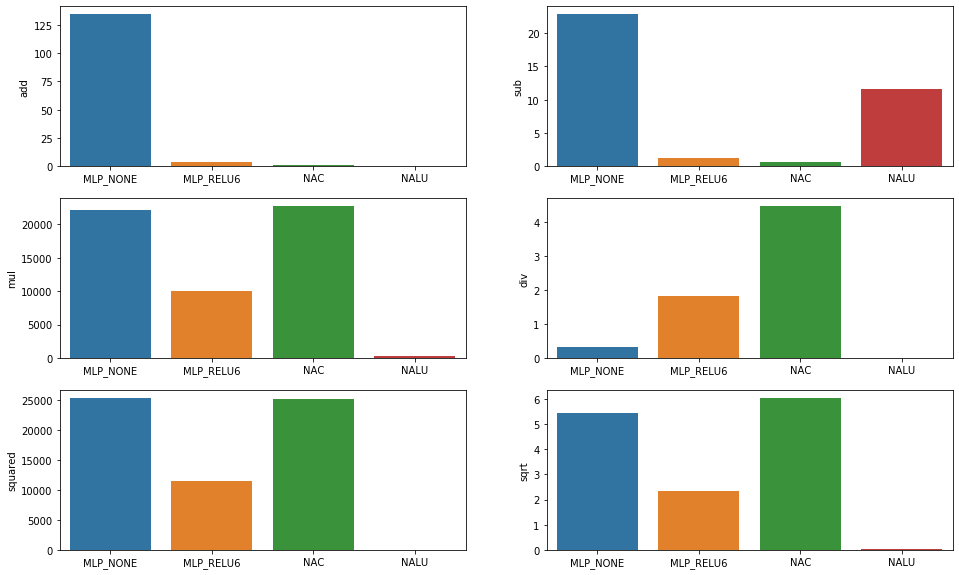

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(16,10))
axs = axs.flatten()

sns.barplot(x=df_interp.index, y='add', data=df_extrap, ax=axs[0])
sns.barplot(x=df_interp.index, y='sub', data=df_extrap, ax=axs[1])
sns.barplot(x=df_interp.index, y='mul', data=df_extrap, ax=axs[2])
sns.barplot(x=df_interp.index, y='div', data=df_extrap, ax=axs[3])
sns.barplot(x=df_interp.index, y='squared', data=df_extrap, ax=axs[4])
sns.barplot(x=df_interp.index, y='sqrt', data=df_extrap, ax=axs[5])